# Notebook to show how to analyse the results inferred by PIHAM

The PIHAM probabilistic generative model has been introduced in:

_[1] Flexible inference in heterogeneous and attributed multilayer networks,<br>
     &nbsp;&nbsp;&nbsp;&nbsp;Contisciani M., Hobbhahn M., Power E.A., Hennig P., and De Bacco C., (2024),
    <a href="https://arxiv.org/abs/2405.20918" target="_blank">ArXiv</a>_
    
This model is designed to perform probabilistic inference in directed and undirected
heterogeneous and attributed multilayer networks. At its core, PIHAM assumes the existence
of a mixed-membership community structure that drives the generation of both interactions
and node attributes. In addition, the inference of the parameters is performed within
a Bayesian framework, where both prior and posterior distributions are
modeled with Gaussian distributions.

In [1]:
import math
import numpy as np
import torch
import pandas as pd
from scipy.stats import norm, dirichlet
import seaborn as sns
import matplotlib.pyplot as plt
from src import tools

In [2]:
sns.set_theme()
sns.set_style("whitegrid", {"axes.grid": False, 'figure.facecolor': 'white', 'axes.edgecolor': 'grey'})
params = {"font.family":"serif", 
          "font.serif":"Computer Modern",
          "text.usetex":True,
          "text.latex.preamble": r"\usepackage{amsfonts}"}
plt.rcParams.update(params)

colors = {0: "#006BA4", 1: "#A48B00", 2: "#C85200"}

np.random.seed(0)

### Import data

We analyze a heterogeneous and attributed multilayer network with $L = 3$ layers: one with binary interactions, the second with nonnegative discrete weights, and the third with real values. Additionally, each node is associated with three covariates: one categorical with $Z = 4$ categories, one with nonnegative discrete values, and the last with real values. This network has been generated by running the script `main_generation.py`, which employs the PIHAM approach as implemented by the `StandardPIHAM` class within the `src/synthetic.py` file.

In [3]:
device = "cpu"

data = torch.load("data/input/synthetic_data.pt")

A = data["A"].to(device).numpy()  # adjacency tensor
X_categorical = data["X_categorical"].to(device).numpy()  # categorical covariates
X_poisson = data["X_poisson"].to(device).numpy()  # Poisson covariates
X_gaussian = data["X_gaussian"].to(device).numpy()  # Gaussian covariates

In [4]:
# Save variables
N = A.shape[1]  # number of nodes
L = A.shape[0]  # number of layers
Z_categorical = X_categorical.shape[1]  # number of categories for the categorical attribute
P_poisson = X_poisson.shape[1]  # number of Poisson attributes
P_gaussian = X_gaussian.shape[1]  # number of Gaussian attributes

### Visualize input

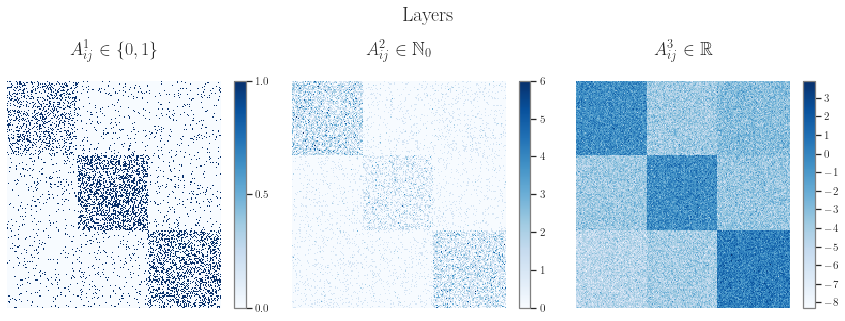

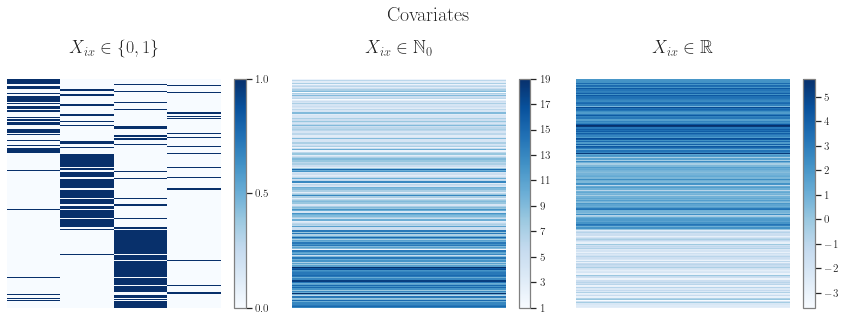

In [5]:
# Plot A
labels_layers = {0: r"$A_{ij}^{1} \in \{0, 1\}$", 
                 1: r"$A_{ij}^{2} \in \mathbb{N}_0$", 
                 2: r"$A_{ij}^{3} \in \mathbb{R}$"}
fig, ax = plt.subplots(1, 3, figsize=(12, 4.5))
fig.suptitle("Layers", fontsize=20)
for layer in np.arange(L):
    plot0 = ax[layer].matshow(A[layer], aspect="auto", cmap="Blues")
    if layer == 0:
        fig.colorbar(plot0, ax=ax[layer], ticks=np.arange(np.round(np.min(A[layer]), 0),
                                                          np.round(np.max(A[layer]), 0)+0.5, 0.5))
    else:
        fig.colorbar(plot0, ax=ax[layer], ticks=np.arange(np.round(np.min(A[layer]), 0),
                                                          np.round(np.max(A[layer]), 0)+1, 1))
    ax[layer].axis("off")
    ax[layer].set_title(labels_layers[layer], fontsize=18)
plt.tight_layout()

# Plot X
fig, ax = plt.subplots(1, 3, figsize=(12, 4.5))
fig.suptitle("Covariates", fontsize=20)
# Categorical attribute
plot0 = ax[0].matshow(X_categorical, aspect="auto", cmap="Blues")
fig.colorbar(plot0, ax=ax[0], ticks=np.arange(np.round(np.min(X_categorical), 0), 
                                              np.round(np.max(X_categorical), 0)+0.5, 0.5))
ax[0].axis("off")
ax[0].set_title(r"$X_{ix} \in \{0, 1\}$", fontsize=18)
# Poisson attribute
plot0 = ax[1].matshow(X_poisson, aspect="auto", cmap="Blues")
fig.colorbar(plot0, ax=ax[1], ticks=np.arange(np.round(np.min(X_poisson), 0),
                                              np.round(np.max(X_poisson), 0)+2, 2))
ax[1].axis("off")
ax[1].set_title(r"$X_{ix} \in \mathbb{N}_0$", fontsize=18)
# Gaussian attribute
plot0 = ax[2].matshow(X_gaussian, aspect="auto", cmap="Blues")
fig.colorbar(plot0, ax=ax[2], ticks=np.arange(np.round(np.min(X_gaussian), 0),
                                              np.round(np.max(X_gaussian), 0)+1, 1))
ax[2].axis("off")
ax[2].set_title(r"$X_{ix} \in \mathbb{R}$", fontsize=18)

plt.tight_layout()
plt.show()

### Import parameters

PIHAM describes the structure of attributed multilayer networks, represented by $A$ and $X$, through the following latent variables:

- $U$: The out-going membership matrix of dimension $N \times K$
- $V$: The in-coming membership matrix of dimension $N \times K$
- $W$: The affinity tensor of dimension $L \times K \times K$
- $Hcategorical$: The community-covariate matrix related to the categorical attribute of dimension $K \times Z_{categorical}$
- $Hpoisson$: The community-covariate matrix related to the Poisson attributes of dimension $K \times P_{poisson}$
- $Hgaussian$: The community-covariate matrix related to the Gaussian attributes of dimension $K \times P_{gaussian}$

In [6]:
parameters = ["U", "V", "W", "Hcategorical", "Hpoisson", "Hgaussian"]

# Ground-truth parameters used to generate the network
theta_gt = torch.load("data/input/theta_gt_synthetic_data.pt")
for par in parameters:
    theta_gt[par] = theta_gt[par].to(device).numpy()
    
K = theta_gt[par].shape[0]  # number of communities

PIHAM employs a Bayesian framework for parameter inference, leading to the estimation of posterior distributions. Specifically, it approximates each posterior using a Gaussian distribution through the application of Laplace Approximation. This technique involves a second-order Taylor expansion around the Maximum A Posteriori estimate (MAP) of the log-posterior distribution. To compute the MAP estimates, PIHAM utilizes Automatic Differentiation, a gradient-based method. The MAP estimate obtained with AD also serves as the mean of the Gaussian posterior distributions of the parameters. To extend beyond point estimates and quantify uncertainty, PIHAM further estimates the covariance matrix, given by the inverted Hessian around the MAP.

In [7]:
# MAP estimates inferred by PIHAM
theta_inferred = np.load("data/output/theta_synthetic_data_K3.npz")

# Permute the inferred results to avoid label switching
MAP_estimates = {}
P = {}
for par in parameters:
    if par.startswith("H"):
        P[par] = tools.calculate_permutation(theta_gt[par].T, theta_inferred[par].T)
        MAP_estimates[par] = np.matmul(P[par].T, theta_inferred[par])
    elif par != "W":
        P[par] = tools.calculate_permutation(theta_gt[par], theta_inferred[par])
        MAP_estimates[par] = np.matmul(theta_inferred[par], P[par])
    else:
        P[par] = np.zeros_like(theta_inferred[par])
        MAP_estimates[par] = np.zeros_like(theta_inferred[par])
        for layer in range(L):
            P[par][layer] = tools.calculate_permutation(theta_gt[par][layer], theta_inferred[par][layer])
            MAP_estimates[par][layer] = np.matmul(theta_inferred[par][layer], P[par][layer])

### Visualize true and inferred parameters (point estimates)

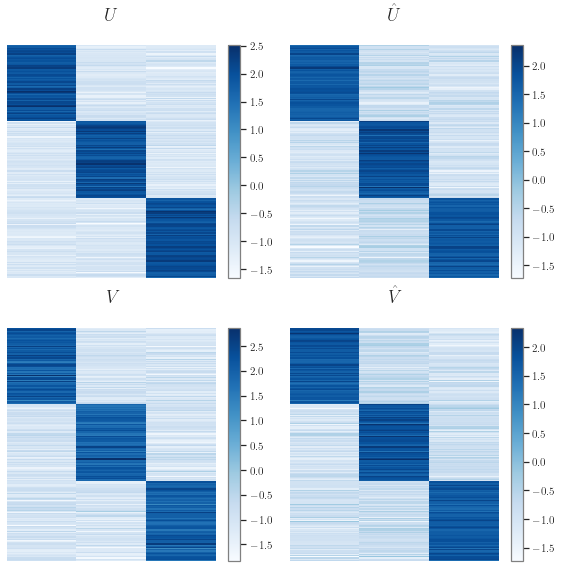

In [8]:
# Plot membership matrices
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, par in enumerate(["U", "V"]):
    plot0 = ax[i, 0].matshow(theta_gt[par], aspect="auto", cmap="Blues")
    fig.colorbar(plot0, ax=ax[i, 0], ticks=np.arange(np.round(np.min(theta_gt[par]), 0), 
                                                     np.round(np.max(theta_gt[par]), 0)+1, 0.5))
    ax[i, 0].axis("off")
    ax[i, 0].set_title(fr"${par}$", fontsize=18)
    plot1 = ax[i, 1].matshow(MAP_estimates[par], aspect="auto", cmap="Blues")
    fig.colorbar(plot1, ax=ax[i, 1], ticks=np.arange(np.round(np.min(MAP_estimates[par]), 0), 
                                                     np.round(np.max(MAP_estimates[par]), 0)+1, 0.5))
    ax[i, 1].axis("off")
    ax[i, 1].set_title(fr"$\hat {par}$", fontsize=18)

plt.tight_layout()
plt.show()

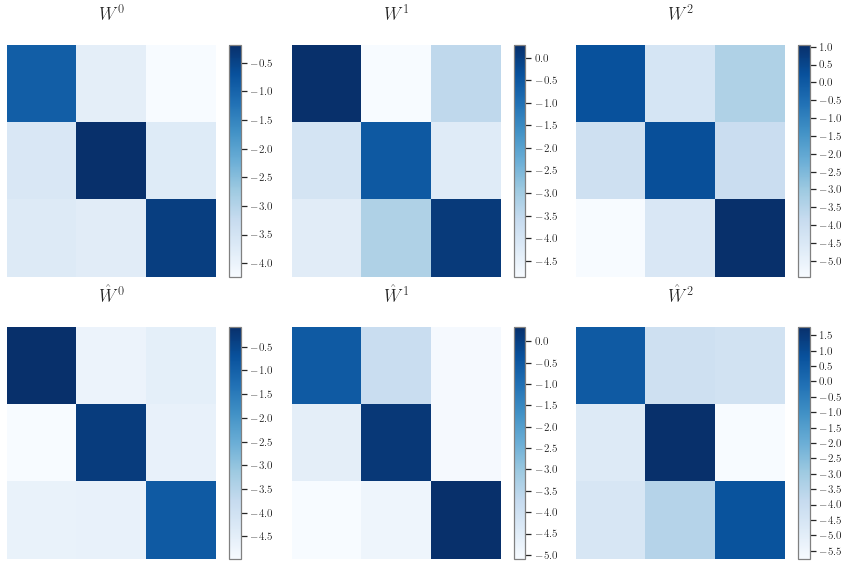

In [9]:
# Plot affinity tensor
par = "W"
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for layer in range(L):
    plot0 = ax[0, layer].matshow(theta_gt[par][layer], aspect="auto", cmap="Blues")
    fig.colorbar(plot0, ax=ax[0, layer], ticks=np.arange(np.round(np.min(theta_gt[par][layer]), 0), 
                                                         np.round(np.max(theta_gt[par][layer]), 0)+1, 0.5))
    ax[0, layer].axis("off")
    ax[0, layer].set_title(fr"${par}^{layer}$", fontsize=18)
    plot1 = ax[1, layer].matshow(MAP_estimates[par][layer], aspect="auto", cmap="Blues")
    fig.colorbar(plot1, ax=ax[1, layer], ticks=np.arange(np.round(np.min(MAP_estimates[par][layer]), 0), 
                                                         np.round(np.max(MAP_estimates[par][layer]), 0)+1, 0.5))
    ax[1, layer].axis("off")
    ax[1, layer].set_title(fr"$\hat {par}^{layer}$", fontsize=18)

plt.tight_layout()
plt.show()

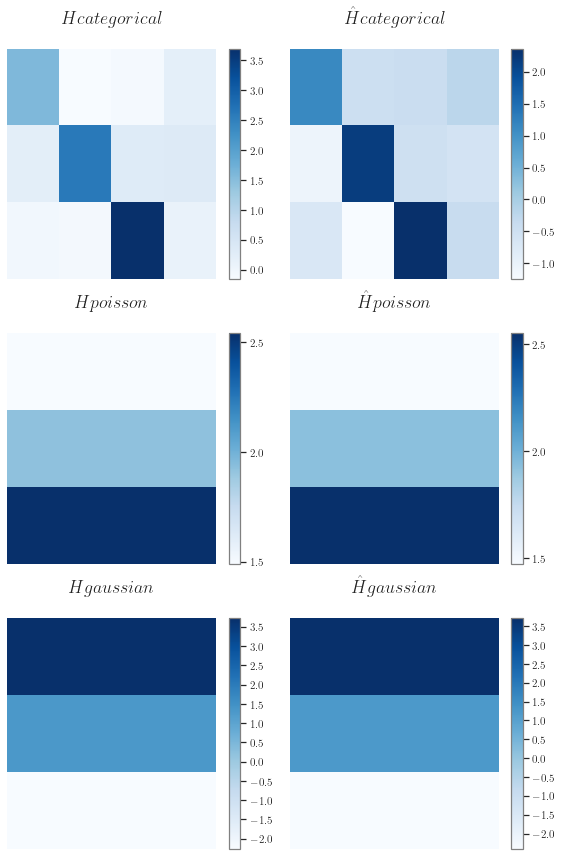

In [10]:
# Plot community-covariate matrices
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
for i, par in enumerate(["Hcategorical", "Hpoisson", "Hgaussian"]):
    plot0 = ax[i, 0].matshow(theta_gt[par], aspect="auto", cmap="Blues")
    fig.colorbar(plot0, ax=ax[i, 0], ticks=np.arange(np.round(np.min(theta_gt[par]), 0), 
                                                     np.round(np.max(theta_gt[par]), 0)+1, 0.5))
    ax[i, 0].axis("off")
    ax[i, 0].set_title(fr"${par}$", fontsize=18)
    plot1 = ax[i, 1].matshow(MAP_estimates[par], aspect="auto", cmap="Blues")
    fig.colorbar(plot1, ax=ax[i, 1], ticks=np.arange(np.round(np.min(MAP_estimates[par]), 0), 
                                                     np.round(np.max(MAP_estimates[par]), 0)+1, 0.5))
    ax[i, 1].axis("off")
    ax[i, 1].set_title(fr"$\hat {par}$", fontsize=18)

plt.tight_layout()
plt.show()

### Visualize true and inferred parameters (posterior distributions)

As previously mentioned, PIHAM estimates Gaussian posterior distributions for the parameters. To display them, we need to upload the inferred variances. 

For the sake of visualization clarity, we present only an example with the out-going memberships for a random node, that is $\hat{U}_{ik} \sim \mathcal{N}(\hat{U}_{ik}; \hat{\mu}^{U}_{ik}, (\hat{\sigma}^2_{ik})^{U})$. To quantitatively interpret the posterior distributions, we compute the area of overlap between every pair of distributions for each node and then calculate the average. We name this measure as Overlap, and it ranges from 0 (indicating no overlap) to 1 (representing perfect matching between the distributions). Additionally, we
use the $L_2$-barycenter distribution, which essentially represents a weighted average of the node-community distributions. We quantify this distribution with its variance ($\sigma^2$), where higher values indicate nodes with harder memberships, as the barycenter is more spread due to the individual distributions being more distant from each other.

In [11]:
sns.set_style("whitegrid", {"grid.color": "0.9"})
plt.rcParams.update(params)

In [12]:
# Select a random node
i = np.random.randint(N)
i

172

In [13]:
# Import inferred variances
variances = {}
variances["U"] = theta_inferred["Cov_diag"][:N*K].reshape(N, K)
# Permute the inferred results to avoid label switching
variances["U"] = np.matmul(variances["U"], P["U"])

# Inferred parameters
infer_mean = MAP_estimates["U"][i]
infer_std = np.sqrt(variances["U"][i])

In [14]:
# Set datapoints
x = np.linspace(-4,4,200)
# Compute Overlap
Overlap = np.mean(tools.calculate_Overlap(infer_mean, infer_std))
# Compute L2-barycenter distribution and its variance
L2_barycenter, _, var_L2_barycenter = tools.compute_L2barycenter(x, infer_mean, infer_std)

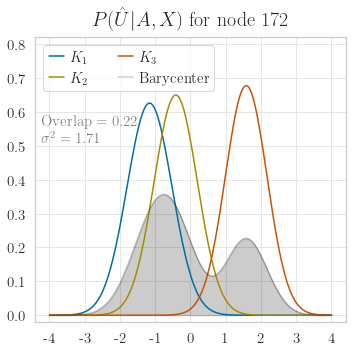

In [15]:
# Plot Gaussian posterior distributions
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for k in range(K):
    infer_dist = norm(loc=infer_mean[k], scale=infer_std[k])
    ax.plot(x, infer_dist.pdf(x), label=fr"$K_{k+1}$", color=colors[k])
    ax.set_xticks(np.arange(-4, 5))
    ax.set_xticklabels(np.arange(-4, 5), size=15)
# Add Overlap
ax.text(-4.25, 0.56, f"Overlap = {np.round(Overlap, 2)}", fontsize=15, color="grey")
# Add L2-barycenter distribution and its variance
ax.plot(x, L2_barycenter, label=f"Barycenter", c="black", alpha=0.2)
ax.fill_between(x, L2_barycenter, color="black", alpha=0.2)
ax.text(-4.25, 0.51, fr"$\sigma^2 = {np.round(var_L2_barycenter, 2)}$", fontsize=15, color="grey")
    
ax.set_title(r"$P(\hat{U}|A,X)$"+f" for node {i}", size=20, pad=12)
ax.set_ylim(-0.02, 0.82)
ax.set_yticks(np.arange(0, 0.82, 0.1))
ax.set_yticklabels(["%.1f" % round(x, 2) for x in np.arange(0.0, 0.82, 0.1)], size=15)
ax.legend(fontsize=15, ncol=2, loc="upper left", handlelength=1, handletextpad=0.4)  

plt.tight_layout()
plt.show()

To enhance interpretability, a practitioner might prefer to work in a different domain. For example, within the simplex space the memberships can be interpreted as probabilities. This can be achieved by applying the softmax function to the membership vector $\hat{U}_i$, which however is not a bijective function and lacks a closed-form transformations. Our framework uses the Laplace Matching technique to approximate the distributions of such transformations. This technique provides a bidirectional, closed-form mapping between the parameters of the Gaussian distribution and those of the approximated transformed distribution, which in this case are Dirichlet distributions.

In [16]:
# Compute the parameter of the Dirichlet posterior distribution
infer_alpha = tools.compute_alpha_from_normal(infer_mean, variances["U"][i]).reshape(-1)

# Define a Dirichlet distribution as in https://gist.github.com/agitter/46b2169a035ad25b5d2b024a00344d54
class Dirichlet(object):
    def __init__(self, alpha):
        """Creates Dirichlet distribution with parameter `alpha`."""
        self._alpha = np.array(alpha)
        self._coef = math.gamma(np.sum(self._alpha)) / \
                     np.multiply.reduce([math.gamma(a) for a in self._alpha])
    def pdf(self, x):
        """Returns pdf value for `x`."""
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                                for (xx, aa)in zip(x, self._alpha)])

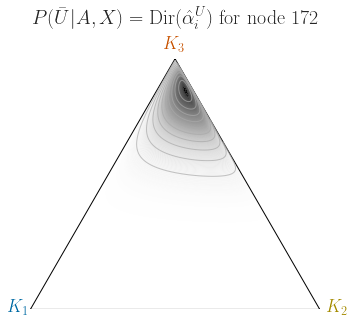

In [17]:
# Plot the Dirichlet posterior distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
infer_dist = Dirichlet(infer_alpha)
tools.draw_Dirichlet(infer_dist, ax)
ax.set_title(r"$P(\bar{U}|A,X) = $ Dir$(\hat{\alpha}^U_i)$"+f" for node {i}", size=20, pad=35)
ax.text(-0.08, -0.01, s=r"$K_1$", color=colors[0], fontsize=18)
ax.text(1.02, -0.01, s=r"$K_2$", color=colors[1], fontsize=18)
ax.text(0.46, 0.9, s=r"$K_3$", color=colors[2], fontsize=18)

plt.tight_layout()
plt.show()

### Assess prediction performance

We assess the performance of PIHAM by evaluating its predictive capabilities through a 5-fold cross-validation
routine. For performance metrics, we use different measures depending on the type of information being evaluated.
For binary interactions, we use the Area Under the Curve (AUC), which represents the probability that a randomly
selected edge has a higher expected value than a randomly selected non-existing edge. The AUC ranges from 0 to
1, with 0.5 representing the random baseline. For nonnegative discrete data, we use the Maximum Absolute Error
(MAE), and for real values, we use the Root Mean Squared Error (RMSE). In both cases, lower values indicate better
performance. Additionally, for categorical attribute predictions, we use accuracy, which ranges from 0 to 1, with 1
indicating perfect recovery. The results are obtained by running the file `main_cv.py`.

In [18]:
cv_results = pd.read_csv("data/output/cv/cv_synthetic_data.csv")
assert len(cv_results)==5

In [19]:
cv_results

,K,fold,rseed,auc_train_AB,auc_test_AB,mean_mae_AP,mae_train_AP,mae_test_AP,mean_rmse_AG,rmse_train_AG,...,rp_XB,mrf_XB,acc_train_XB,acc_test_XB,mean_mae_XP,mae_train_XP,mae_test_XP,mean_rmse_XG,rmse_train_XG,rmse_test_XG
0,3,0,0,0.775595,0.763825,0.485934,0.378879,0.364243,2.098783,1.182273,...,0.25,0.375,0.73125,0.825,[3.7],[2.5189538],[2.8378282],[2.2332277],[1.0380667],[1.0821921]
1,3,1,0,0.776154,0.762640,0.490406,0.377253,0.374009,2.083017,1.177859,...,0.25,0.400,0.76250,0.700,[3.2287498],[2.4173672],[2.8626504],[2.3143942],[1.057918],[1.1901248]
2,3,2,0,0.772250,0.775765,0.495210,0.375049,0.381363,2.075967,1.182584,...,0.25,0.375,0.76875,0.675,[3.0771873],[2.5047216],[2.2582927],[2.4066775],[1.1112227],[1.1570729]
3,3,3,0,0.770432,0.773881,0.498790,0.373342,0.387178,2.072962,1.171943,...,0.25,0.325,0.73125,0.825,[3.1028123],[2.3877056],[2.3266037],[2.1040637],[1.0789374],[1.0298578]
4,3,4,0,0.773985,0.765104,0.493302,0.375977,0.376378,2.097513,1.181872,...,0.25,0.400,0.75625,0.725,[3.302812],[2.6010787],[2.5025048],[2.3334281],[1.0844259],[1.0148746]


In [20]:
for column in ["mean_mae_XP", "mae_train_XP", "mae_test_XP", "mean_rmse_XG", "rmse_train_XG", "rmse_test_XG"]:
    cv_results[column] = cv_results[column].apply(lambda a: float(a[1:-1]))

In [21]:
cv_results.groupby("K").mean()

,fold,rseed,auc_train_AB,auc_test_AB,mean_mae_AP,mae_train_AP,mae_test_AP,mean_rmse_AG,rmse_train_AG,rmse_test_AG,rp_XB,mrf_XB,acc_train_XB,acc_test_XB,mean_mae_XP,mae_train_XP,mae_test_XP,mean_rmse_XG,rmse_train_XG,rmse_test_XG
K,,,,,,,,,,,,,,,,,,,,
3,2.0,0.0,0.773683,0.768243,0.492728,0.3761,0.376634,2.085648,1.179306,1.212786,0.25,0.375,0.75,0.75,3.282312,2.485965,2.557576,2.278358,1.074114,1.094824


In [22]:
cv_results.groupby("K").std()

,fold,rseed,auc_train_AB,auc_test_AB,mean_mae_AP,mae_train_AP,mae_test_AP,mean_rmse_AG,rmse_train_AG,rmse_test_AG,rp_XB,mrf_XB,acc_train_XB,acc_test_XB,mean_mae_XP,mae_train_XP,mae_test_XP,mean_rmse_XG,rmse_train_XG,rmse_test_XG
K,,,,,,,,,,,,,,,,,,,,
3,1.581139,0.0,0.00237,0.006106,0.004868,0.002108,0.008574,0.011988,0.00454,0.01284,0.0,0.030619,0.017678,0.070711,0.251022,0.085223,0.281764,0.115339,0.027696,0.077022
